In [ ]:
!pip install -q transformers torch torchvision pillow imageio

In [14]:
import math
from typing import List, Tuple

import numpy as np
import matplotlib.pyplot as plt

import torch
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import io

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [17]:
#loading VLM (CLIP)
MODEL_NAME = "openai/clip-vit-base-patch32"

model = CLIPModel.from_pretrained(MODEL_NAME).to(device)
processor = CLIPProcessor.from_pretrained(MODEL_NAME)

print("Loaded CLIP model:", MODEL_NAME)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

Loaded CLIP model: openai/clip-vit-base-patch32


CLIP est un vision–language transformer : un encodeur d’images + un encodeur de texte dans le même espace d’embedding. On peut donc comparer image et texte par similarité.

In [37]:
#environnemennt gridworld
FREE = 0
OBST = 1

class GridWorld:
    def __init__(self, grid: np.ndarray, start: Tuple[int, int], goal: Tuple[int, int]):
        self.grid = grid.copy()
        self.rows, self.cols = grid.shape
        self.start = start
        self.goal = goal
        self.reset()

    def reset(self):
        """Reset agent to start position and return initial state."""
        self.agent_pos = tuple(self.start)
        return self.agent_pos

    def in_bounds(self, cell):
        """Check if a cell is inside the grid."""
        r, c = cell
        return 0 <= r < self.rows and 0 <= c < self.cols

    def passable(self, cell):
        """Check if a cell is free (not an obstacle)."""
        r, c = cell
        return self.grid[r, c] == FREE

    def neighbors(self, cell):
        """Return 4-connected free neighbors of the given cell."""
        r, c = cell
        steps = [
          (1, 0), (-1, 0), (0, 1), (0, -1),
          (1, 1), (1, -1), (-1, 1), (-1, -1),
        ]
        result = []
        for dr, dc in steps:
            nr, nc = r + dr, c + dc
            nxt = (nr, nc)
            if self.in_bounds(nxt) and self.passable(nxt):
                result.append(nxt)
        return result

    def is_goal(self, cell):
        """Check if a cell is the goal."""
        return cell == self.goal

    def step(self, next_pos):
        """Move the agent to next_pos if valid; return new state and done flag."""
        if next_pos in self.neighbors(self.agent_pos):
            self.agent_pos = next_pos
        done = self.is_goal(self.agent_pos)
        return self.agent_pos, done


In [38]:
#grid example
def create_example_grid():
    grid = np.zeros((10, 15), dtype=int)
    # Horizontal wall
    grid[4, 1:13] = OBST
    grid[4, 7] = FREE  # gap in the wall
    start = (8, 1)
    goal = (1, 13)
    return grid, start, goal

grid, start, goal = create_example_grid()
env = GridWorld(grid, start, goal)

print("Grid shape:", grid.shape)
print("Start:", start, "Goal:", goal)


Grid shape: (10, 15)
Start: (8, 1) Goal: (1, 13)


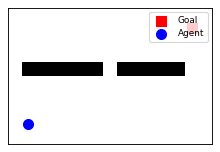

In [39]:
#Image rendering
def render_grid_to_image(env: GridWorld, dpi: int = 80) -> Image.Image:
    fig, ax = plt.subplots(figsize=(3, 2), dpi=dpi)
    ax.imshow(env.grid, cmap="Greys", origin="upper")

    # Goal (red square)
    gr, gc = env.goal
    ax.scatter(gc, gr, c="red", s=80, marker="s", label="Goal")

    # Agent (blue circle)
    ar, ac = env.agent_pos
    ax.scatter(ac, ar, c="blue", s=80, marker="o", label="Agent")

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(-0.5, env.cols - 0.5)
    ax.set_ylim(env.rows - 0.5, -0.5)

    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(loc="upper right", fontsize=8)

    plt.tight_layout()

    buf = io.BytesIO()
    plt.savefig(buf, format="png", bbox_inches="tight")
    plt.close(fig)
    buf.seek(0)
    img = Image.open(buf).convert("RGB")
    return img

# Test
env.reset()
img = render_grid_to_image(env)
display(img)


In [40]:
#Image/text similarity with CLIP
def clip_score_image_text(image: Image.Image, text: str) -> float:
    """Compute CLIP similarity score between a single image and a text prompt."""
    inputs = processor(text=[text], images=[image], return_tensors="pt", padding=True).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        logits_per_image = outputs.logits_per_image  # shape (1, 1)
    return logits_per_image[0, 0].item()

INSTRUCTION = (
    "The blue agent should move through the gap in the wall "
    "and reach the red square goal in the top part of the grid, avoiding obstacles."
)

In [41]:
#Planning loop
def vlm_planning_episode(env: GridWorld, instruction: str, max_steps: int = 150):
    trajectory: List[Tuple[int, int]] = []
    scores_history = []

    env.reset()
    trajectory.append(env.agent_pos)

    for _ in range(max_steps):
        if env.is_goal(env.agent_pos):
            break

        neighbors = env.neighbors(env.agent_pos)
        if not neighbors:
            break

          # éviter de revenir immédiatement à la case précédente
        if len(trajectory) >= 2:
            prev_pos = trajectory[-2]
            neighbors = [nb for nb in neighbors if nb != prev_pos]
            if not neighbors:
                break

        best_score = -1e9
        best_neighbor = None
        step_scores = {}




        def manhattan(cell, goal):
            r, c = cell
            gr, gc = goal
            return abs(r - gr) + abs(c - gc)

        beta = 0.5  # pondération de la distance

        for nb in neighbors:
          # simulate move
            old_pos = env.agent_pos
            env.agent_pos = nb
            img = render_grid_to_image(env)
            score_clip = clip_score_image_text(img, instruction)
            env.agent_pos = old_pos

            d_goal = manhattan(nb, env.goal)
            combined = score_clip - beta * d_goal

            if combined > best_score:
                best_score = combined
                best_neighbor = nb


        # for nb in neighbors:
        #     # simulate move
        #     old_pos = env.agent_pos
        #     env.agent_pos = nb
        #     img = render_grid_to_image(env)
        #     score = clip_score_image_text(img, instruction)
        #     step_scores[nb] = score
        #     # restore
        #     env.agent_pos = old_pos

        #     if score > best_score:
        #         best_score = score
        #         best_neighbor = nb

        scores_history.append(step_scores)

        # real move
        new_state, done = env.step(best_neighbor)
        trajectory.append(new_state)

        if done:
            break

    return trajectory, scores_history

traj, scores_hist = vlm_planning_episode(env, INSTRUCTION, max_steps=50)
print("Trajectory length:", len(traj))
print("Reached goal?", traj[-1] == env.goal)
traj


Trajectory length: 16
Reached goal? True


[(8, 1),
 (7, 2),
 (6, 3),
 (5, 4),
 (6, 5),
 (6, 6),
 (7, 7),
 (7, 8),
 (6, 9),
 (6, 10),
 (6, 11),
 (5, 12),
 (4, 13),
 (3, 13),
 (2, 13),
 (1, 13)]

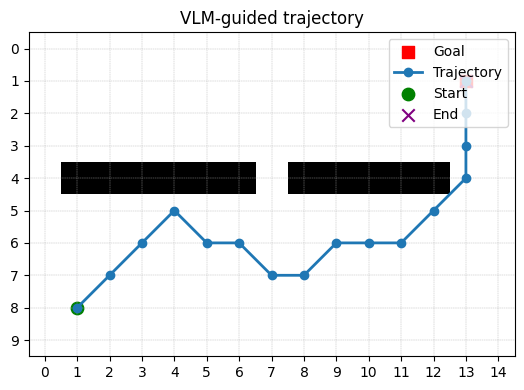

In [42]:
#Visualize the VLM trajectory
def plot_trajectory(env: GridWorld, trajectory: List[Tuple[int, int]]):
    grid = env.grid
    rows, cols = grid.shape

    fig, ax = plt.subplots(figsize=(6, 4))
    ax.imshow(grid, cmap="Greys", origin="upper")

    # Goal
    gr, gc = env.goal
    ax.scatter(gc, gr, c="red", s=80, marker="s", label="Goal")

    # Trajectory
    ys = [r for (r, c) in trajectory]
    xs = [c for (r, c) in trajectory]
    ax.plot(xs, ys, c="tab:blue", linewidth=2, marker="o", label="Trajectory")

    # Start & End
    sr, sc = trajectory[0]
    ax.scatter(sc, sr, c="green", s=80, marker="o", label="Start")
    er, ec = trajectory[-1]
    ax.scatter(ec, er, c="purple", s=80, marker="x", label="End")

    ax.set_xticks(range(cols))
    ax.set_yticks(range(rows))
    ax.set_xlim(-0.5, cols - 0.5)
    ax.set_ylim(rows - 0.5, -0.5)
    ax.grid(True, linestyle="--", linewidth=0.3)
    ax.set_title("VLM-guided trajectory")
    ax.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

plot_trajectory(env, traj)



In [43]:
#Inspect CLIP scores
if scores_hist:
    step0 = scores_hist[0]
    print("Scores for neighbors at step 0:")
    for nb, sc in step0.items():
        print(f"  neighbor {nb}: score {sc:.3f}")
else:
    print("No scores recorded.")



Scores for neighbors at step 0:


In [45]:
# import heapq

# def manhattan(a: Tuple[int,int], b: Tuple[int,int]) -> int:
#     return abs(a[0] - b[0]) + abs(a[1] - b[1])

# def astar_shortest_path(env: GridWorld):
#     start, goal = env.start, env.goal
#     open_set = []
#     heapq.heappush(open_set, (manhattan(start, goal), 0, start))
#     came_from = {}
#     g_score = {start: 0}
#     closed = set()

#     while open_set:
#         f, g, current = heapq.heappop(open_set)
#         if current in closed:
#             continue
#         if current == goal:
#             path = [current]
#             while current in came_from:
#                 current = came_from[current]
#                 path.append(current)
#             path.reverse()
#             return path
#         closed.add(current)
#         for nb in env.neighbors(current):
#             tentative_g = g_score[current] + 1
#             if tentative_g < g_score.get(nb, math.inf):
#                 g_score[nb] = tentative_g
#                 came_from[nb] = current
#                 f_score = tentative_g + manhattan(nb, goal)
#                 heapq.heappush(open_set, (f_score, tentative_g, nb))
#     return None

# astar_path = astar_shortest_path(env)
# print("A* path length:", len(astar_path) if astar_path is not None else None)

# if astar_path is not None:
#     plot_trajectory(env, astar_path)
